In [1]:
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info.operators import Operator

backend = Aer.get_backend("qasm_simulator")
from qiskit.visualization import plot_histogram

from utils_decompose import multiplexor, demultiplexor, unitary_diag, cos_sin_decomposition
from utils_decompose import zyz_decomposition, ucry_decomposition_optimize, ucrz_decomposition, global_phase_gate
from utils import universal_ud

Original matrix:
 [[ 0.069-0.393j  0.258-0.271j -0.82 +0.141j  0.041+0.077j]
 [ 0.143-0.033j -0.647-0.277j -0.147-0.151j -0.661-0.049j]
 [ 0.48 -0.654j -0.049+0.287j  0.237+0.189j -0.001-0.407j]
 [-0.321-0.243j -0.529-0.003j -0.131-0.392j  0.594-0.185j]]
Reconstruct matrix:
 [[ 0.069-0.393j  0.258-0.271j -0.82 +0.141j  0.041+0.077j]
 [ 0.143-0.033j -0.647-0.277j -0.147-0.151j -0.661-0.049j]
 [ 0.48 -0.654j -0.049+0.287j  0.237+0.189j -0.001-0.407j]
 [-0.321-0.243j -0.529-0.003j -0.131-0.392j  0.594-0.185j]]


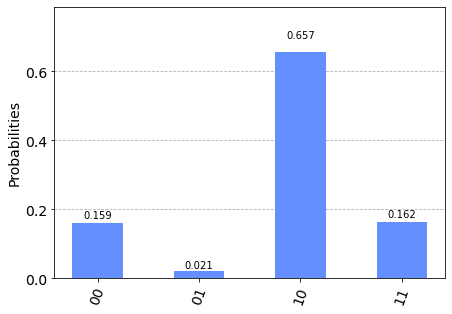

In [2]:
r = np.random.RandomState(77)

N = 2
M = unitary_group.rvs(2**N,random_state=r)
print("Original matrix:\n",np.round(M,3))

U, CS, V = cos_sin_decomposition(M,N)

U1,D1,V1 = demultiplexor(U,N)
U2,D2,V2 = demultiplexor(V,N)

rcst_U = multiplexor(U1,D1,V1,N)
uni_D1 = unitary_diag(D1,N)

rcst_V = multiplexor(U2,D2,V2,N)
uni_D2 = unitary_diag(D2,N)

print("Reconstruct matrix:\n", np.round(rcst_U@CS@rcst_V,3))

qc = QuantumCircuit(N)

qc.unitary(Operator(M),range(N))
qc.measure_all()

result = execute(qc, backend=backend,shots=4096).result()
plot_histogram(result.get_counts())

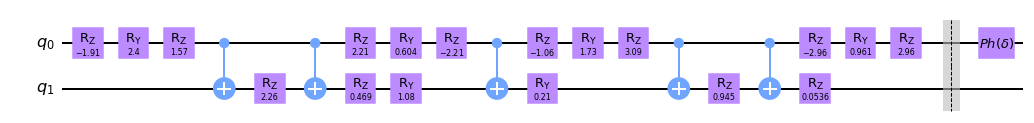

In [3]:
qc = QuantumCircuit(2)
phase = 0


##################################################
##### Optimized MxorRy 

mxory_optimize = np.eye(len(V))
for i in range(len(V)//4): mxory_optimize[(len(V)//2+2*i+1)][(len(V)//2+2*i+1)] = -1
V = mxory_optimize@V

U1,D1,V1 = demultiplexor(U,N)
U2,D2,V2 = demultiplexor(V,N)

##################################################

phase = zyz_decomposition(qc,V2,0,phase)
ucrz_decomposition(qc,N,D2,[0,1])
phase = zyz_decomposition(qc,U2,0,phase)

ucry_decomposition_optimize(qc,N,CS,[0,1])

phase = zyz_decomposition(qc,V1,0,phase)
ucrz_decomposition(qc,N,D1,[0,1])
phase = zyz_decomposition(qc,U1,0,phase)

qc.barrier()
global_phase_gate(qc,phase,0)

qc.draw(output="mpl",fold=-1)

Original matrix:
 [[ 0.069-0.393j  0.258-0.271j -0.82 +0.141j  0.041+0.077j]
 [ 0.143-0.033j -0.647-0.277j -0.147-0.151j -0.661-0.049j]
 [ 0.48 -0.654j -0.049+0.287j  0.237+0.189j -0.001-0.407j]
 [-0.321-0.243j -0.529-0.003j -0.131-0.392j  0.594-0.185j]]
Circuit matrix:
 [[ 0.069-0.393j  0.258-0.271j -0.82 +0.141j  0.041+0.077j]
 [ 0.143-0.033j -0.647-0.277j -0.147-0.151j -0.661-0.049j]
 [ 0.48 -0.654j -0.049+0.287j  0.237+0.189j -0.001-0.407j]
 [-0.321-0.243j -0.529-0.003j -0.131-0.392j  0.594-0.185j]]


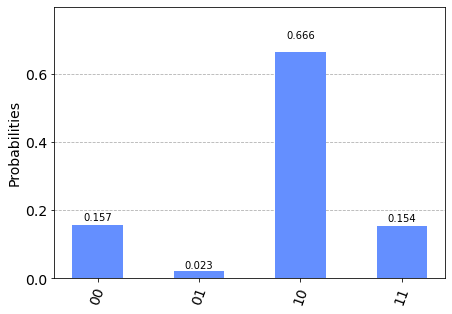

In [4]:
print("Original matrix:\n",np.round(M,3))
print("Circuit matrix:\n",np.round(np.matrix(Operator(qc)),3))
qc.measure_all()

result = execute(qc, backend=backend,shots=4096).result()
plot_histogram(result.get_counts())

Cartan Decomposition

Original matrix:
 [[ 0.069-0.393j  0.258-0.271j -0.82 +0.141j  0.041+0.077j]
 [ 0.143-0.033j -0.647-0.277j -0.147-0.151j -0.661-0.049j]
 [ 0.48 -0.654j -0.049+0.287j  0.237+0.189j -0.001-0.407j]
 [-0.321-0.243j -0.529-0.003j -0.131-0.392j  0.594-0.185j]]
Circuit matrix:
 [[ 0.069-0.393j  0.258-0.271j -0.82 +0.141j  0.041+0.077j]
 [ 0.143-0.033j -0.647-0.277j -0.147-0.151j -0.661-0.049j]
 [ 0.48 -0.654j -0.049+0.287j  0.237+0.189j -0.001-0.407j]
 [-0.321-0.243j -0.529-0.003j -0.131-0.392j  0.594-0.185j]]


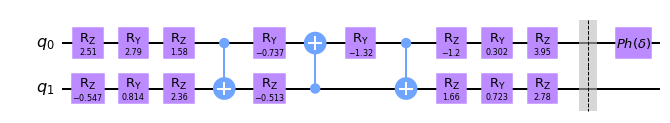

In [5]:
qc = QuantumCircuit(2)

phase = 0
phase = universal_ud(qc,M,[0,1],phase)

qc.barrier()
global_phase_gate(qc,phase,0)

print("Original matrix:\n",np.round(M,3))
print("Circuit matrix:\n",np.round(np.matrix(Operator(qc)),3))

qc.draw(output="mpl",fold=-1)